In [7]:
%matplotlib notebook


# Poly Editor

This is an example to show how to build cross-GUI applications using
Matplotlib event handling to interact with objects on the canvas.

<div class="alert alert-info"><h4>Note</h4><p>This example exercises the interactive capabilities of Matplotlib, and this
    will not appear in the static documentation. Please run this code on your
    machine to see the interactivity.

    You can copy and paste individual parts, or download the entire example
    using the link at the bottom of the page.</p></div>


<IPython.core.display.Javascript object>


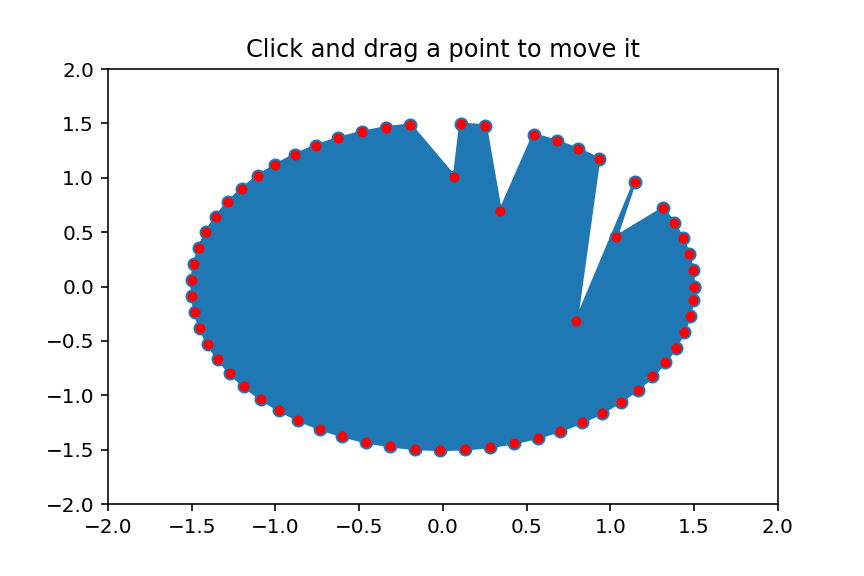

In [8]:
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.artist import Artist


def dist(x, y):
    """
    Return the distance between two points.
    """
    d = x - y
    return np.sqrt(np.dot(d, d))


def dist_point_to_segment(p, s0, s1):
    """
    Get the distance of a point to a segment.
      *p*, *s0*, *s1* are *xy* sequences
    This algorithm from
    http://www.geomalgorithms.com/algorithms.html
    """
    v = s1 - s0
    w = p - s0
    c1 = np.dot(w, v)
    if c1 <= 0:
        return dist(p, s0)
    c2 = np.dot(v, v)
    if c2 <= c1:
        return dist(p, s1)
    b = c1 / c2
    pb = s0 + b * v
    return dist(p, pb)


class PolygonInteractor:
    """
    A polygon editor.

    Key-bindings

      't' toggle vertex markers on and off.  When vertex markers are on,
          you can move them, delete them

      'd' delete the vertex under point

      'i' insert a vertex at point.  You must be within epsilon of the
          line connecting two existing vertices

    """

    showverts = True
    epsilon = 5  # max pixel distance to count as a vertex hit

    def __init__(self, ax, poly):
        if poly.figure is None:
            raise RuntimeError('You must first add the polygon to a figure '
                               'or canvas before defining the interactor')
        self.ax = ax
        canvas = poly.figure.canvas
        self.poly = poly

        x, y = zip(*self.poly.xy)
        self.line = Line2D(x, y,
                           marker='o', markerfacecolor='r',
                           animated=True)
        self.ax.add_line(self.line)

        self.cid = self.poly.add_callback(self.poly_changed)
        self._ind = None  # the active vert

        canvas.mpl_connect('draw_event', self.on_draw)
        canvas.mpl_connect('button_press_event', self.on_button_press)
        canvas.mpl_connect('key_press_event', self.on_key_press)
        canvas.mpl_connect('button_release_event', self.on_button_release)
        canvas.mpl_connect('motion_notify_event', self.on_mouse_move)
        self.canvas = canvas

    def on_draw(self, event):
        self.background = self.canvas.copy_from_bbox(self.ax.bbox)
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)
        # do not need to blit here, this will fire before the screen is
        # updated

    def poly_changed(self, poly):
        """This method is called whenever the pathpatch object is called."""
        # only copy the artist props to the line (except visibility)
        vis = self.line.get_visible()
        Artist.update_from(self.line, poly)
        self.line.set_visible(vis)  # don't use the poly visibility state

    def get_ind_under_point(self, event):
        """
        Return the index of the point closest to the event position or *None*
        if no point is within ``self.epsilon`` to the event position.
        """
        # display coords
        xy = np.asarray(self.poly.xy)
        xyt = self.poly.get_transform().transform(xy)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.hypot(xt - event.x, yt - event.y)
        indseq, = np.nonzero(d == d.min())
        ind = indseq[0]

        if d[ind] >= self.epsilon:
            ind = None

        return ind

    def on_button_press(self, event):
        """Callback for mouse button presses."""
        if not self.showverts:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        self._ind = self.get_ind_under_point(event)

    def on_button_release(self, event):
        """Callback for mouse button releases."""
        if not self.showverts:
            return
        if event.button != 1:
            return
        self._ind = None

    def on_key_press(self, event):
        """Callback for key presses."""
        if not event.inaxes:
            return
        if event.key == 't':
            self.showverts = not self.showverts
            self.line.set_visible(self.showverts)
            if not self.showverts:
                self._ind = None
        elif event.key == 'd':
            ind = self.get_ind_under_point(event)
            if ind is not None:
                self.poly.xy = np.delete(self.poly.xy,
                                         ind, axis=0)
                self.line.set_data(zip(*self.poly.xy))
        elif event.key == 'i':
            xys = self.poly.get_transform().transform(self.poly.xy)
            p = event.x, event.y  # display coords
            for i in range(len(xys) - 1):
                s0 = xys[i]
                s1 = xys[i + 1]
                d = dist_point_to_segment(p, s0, s1)
                if d <= self.epsilon:
                    self.poly.xy = np.insert(
                        self.poly.xy, i+1,
                        [event.xdata, event.ydata],
                        axis=0)
                    self.line.set_data(zip(*self.poly.xy))
                    break
        if self.line.stale:
            self.canvas.draw_idle()

    def on_mouse_move(self, event):
        """Callback for mouse movements."""
        if not self.showverts:
            return
        if self._ind is None:
            return
        if event.inaxes is None:
            return
        if event.button != 1:
            return
        x, y = event.xdata, event.ydata

        self.poly.xy[self._ind] = x, y
        if self._ind == 0:
            self.poly.xy[-1] = x, y
        elif self._ind == len(self.poly.xy) - 1:
            self.poly.xy[0] = x, y
        self.line.set_data(zip(*self.poly.xy))

        self.canvas.restore_region(self.background)
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)
        self.canvas.blit(self.ax.bbox)


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from matplotlib.patches import Polygon

    theta = np.arange(0, 2*np.pi, 0.1)
    r = 1.5

    xs = r * np.cos(theta)
    ys = r * np.sin(theta)

    poly = Polygon(np.column_stack([xs, ys]), animated=True)

    fig, ax = plt.subplots()
    ax.add_patch(poly)
    p = PolygonInteractor(ax, poly)

    ax.set_title('Click and drag a point to move it')
    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))
    plt.show()

In [9]:
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector

<IPython.core.display.Javascript object>


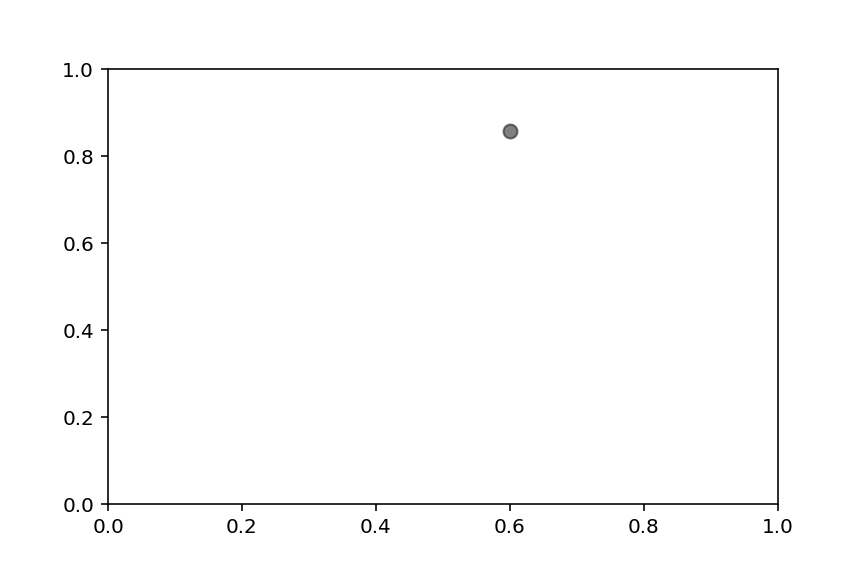

AttributeError: can't set attribute

In [11]:
fig, ax = plt.subplots()
fig.show()

selector = PolygonSelector(ax, lambda *args: None)

# Add three vertices
selector.verts = [(0.1, 0.4), (0.5, 0.9), (0.3, 0.2)]